# **중고차 가격 예측 모델 구현 및 분석**

## 0. 환경 설정

In [ ]:
# 필요한 패키지 다운로드
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap

In [ ]:
# warning ignore
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



---


## 1. 프로젝트 개요

- **1) 문제 정의** : 고금리로인해 중고차 시장이 혼란을 겪으면서 중고차 시세가 뒤죽박죽 양상을 보이고 있다. 중고차 업계 관계자는 고금리로 인해 시세가 엉망이어서 소비자나 차주는 물론 딜러들도 매매 여부를 판단하기 어려운 상황이라고 말했다. 전문가들은 이런 시세 혼란기에는 '좋은 값'을 미끼로 사기치는 사람들은 조심해야하며, 신뢰도 높은 비교 견적이 필수라고 조언하고있다. 때문에 중고차 가격 예측 모델을 통해 가격에 어떤 요소가 가장 큰 영향을 미치는지 확인해보고 손해를 방지하고자 한다. (https://www.mk.co.kr/news/business/10577294)


- **2) 데이터** : Kaggle < Car Price Prediction >  사용

- **3) 변수 설명**
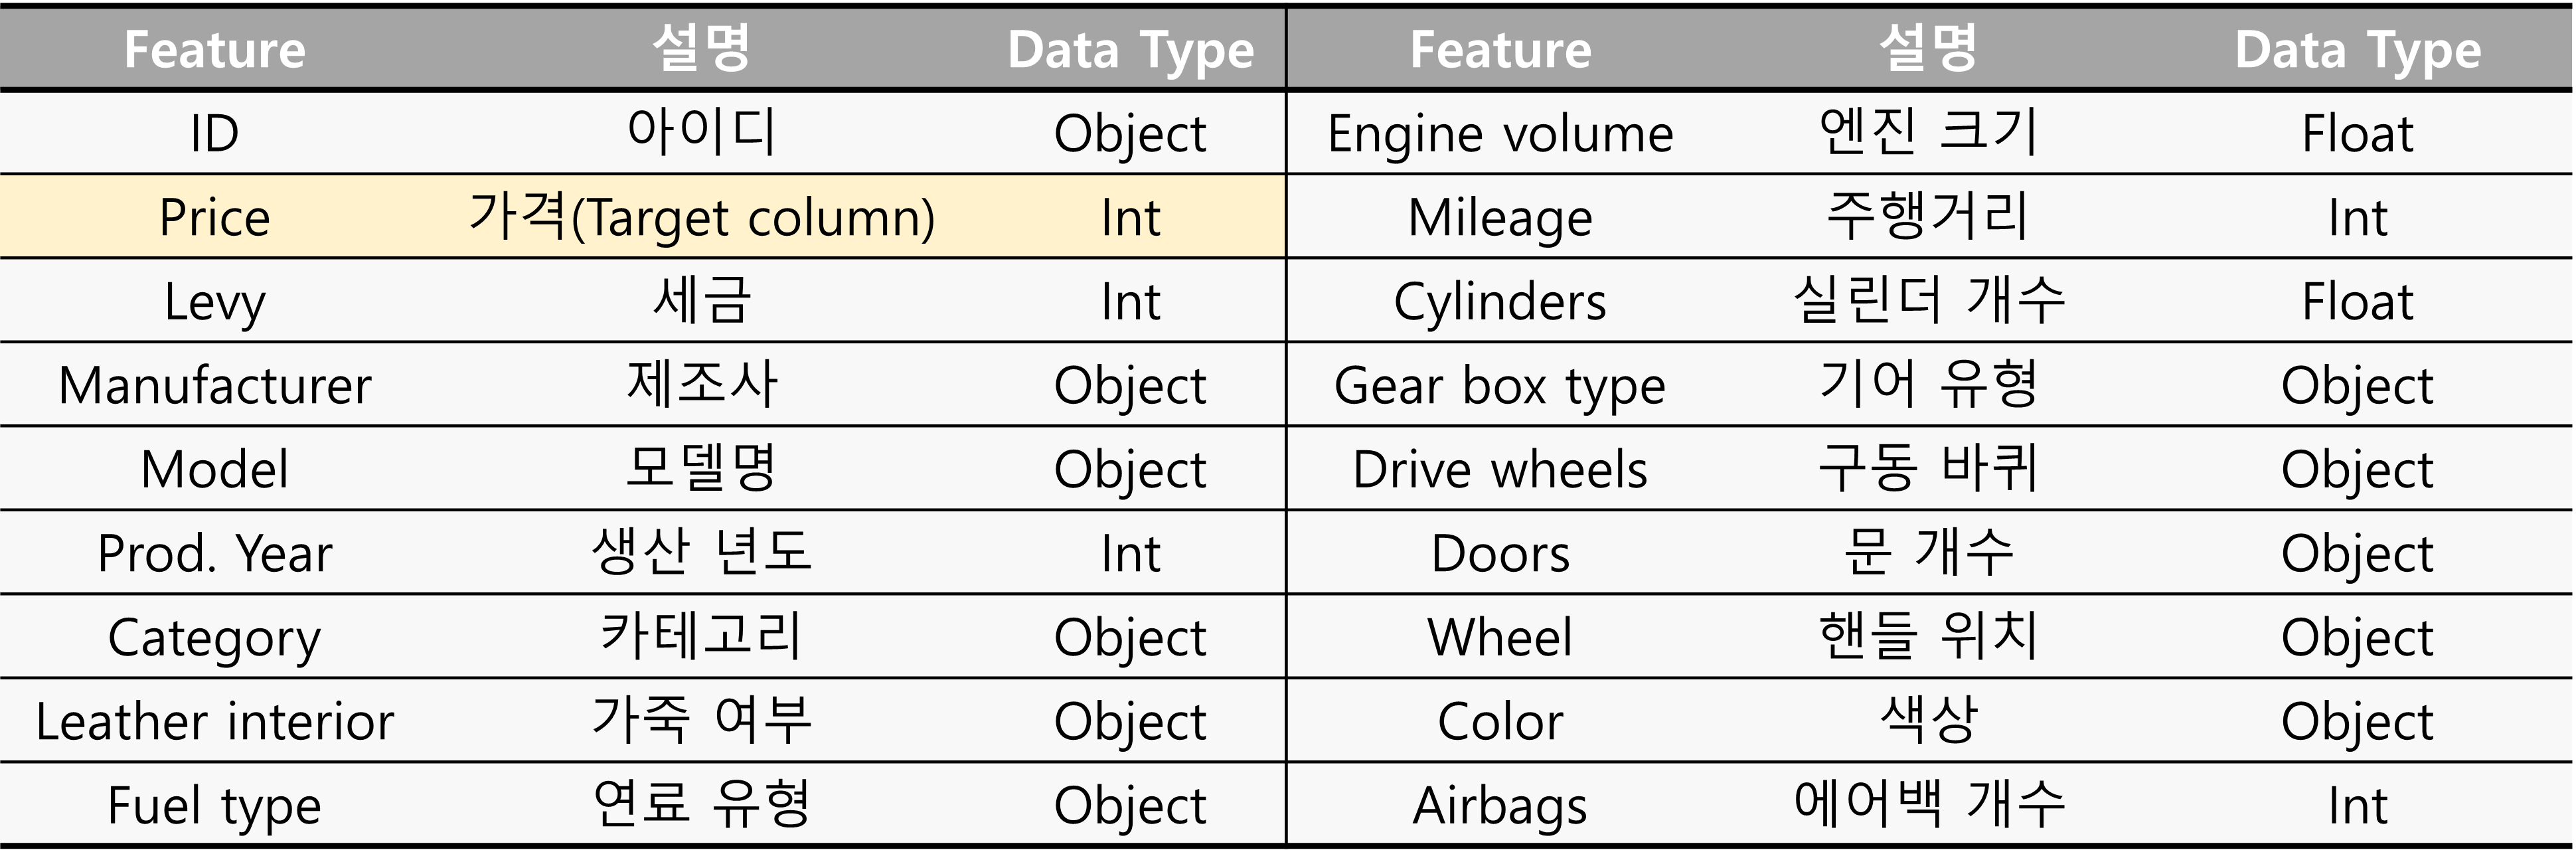

- **4) 가설**
  - Engine volumne이 가격에 가장 큰 영향을 미칠 것이다.
  - Engine volumne이 클수록 가격이 높을 것이다.
  - 최근 생산된 자동차일수록 가격이 높을 것이다.
  - 주행거리가 많을수록 가격이 낮아질 것이다.
- **5) 기준 모델** : Target값인 **Price의 평균값**

- **6) 평가 지표** : R2 Score



## 2. 데이터 불러오기



In [ ]:
import pandas as pd

car = pd.read_csv('car_price_prediction.csv')
car.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [ ]:
# Data Shape 확인
car.shape

(19237, 18)

- 총 18개 변수, 19237개 데이터 존재

## 3. 데이터 전처리 및 Feature Engineering

In [ ]:
# 결측치 및 데이터 타입 확인
isnull = pd.DataFrame(car.isnull().sum(),columns=['isnull'])
dtypes = pd.DataFrame(car.dtypes,columns=['dtypes'])
pd.concat([isnull, dtypes],axis=1).T

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
isnull,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dtypes,int64,int64,object,object,object,int64,object,object,object,object,object,float64,object,object,object,object,object,int64


- 모든 변수에 결측치는 존재하지 않으며, 데이터 타입은 int, float, object로 이루어져 있음

In [ ]:
# 일부 데이터 확인
car[['Levy', 'Engine volume', 'Mileage', 'Doors']]

,Levy,Engine volume,Mileage,Doors
0,1399,3.5,186005 km,04-May
1,1018,3,192000 km,04-May
2,-,1.3,200000 km,04-May
3,862,2.5,168966 km,04-May
4,446,1.3,91901 km,04-May
...,...,...,...,...
19232,-,2.0 Turbo,300000 km,02-Mar
19233,831,2.4,161600 km,04-May
19234,836,2,116365 km,04-May
19235,1288,2,51258 km,04-May


- Levy 변수에 '-' 글자 변환 필요
- Engine volume 변수에 'Turbo' 글자 제거 필요
- Mileage 변수에 'km' 단위 제거 필요
- Doors 변수 오류 수정 필요(May -> 5, Mar -> 3으로 변경 필요)

In [ ]:
# Levy column의 '-'을 0으로 변환
car['Levy'] = car['Levy'].replace('-',0).astype('int64')

# Turbo 엔진 여부 컬럼 생성
car['Turbo'] = car['Engine volume'].astype('str').apply(lambda x : 'Y' if x[-5:]=='Turbo' else 'N')

# Engine volumne의 데이터 중 'Turbo'글자 제거
car['Engine volume'] = car['Engine volume'].str.replace(' Turbo','').astype('float64')

# Milege의 'km'단위 제거
car['Mileage'] = car['Mileage'].str.replace(' km','').astype('int64')

# Doors변수 오류 변경 및 데이터타입 변경
car['Doors'] = car['Doors'].replace('02-Mar','2-3').replace('04-May','4-5').replace('>5','5+')

- Levy 변수의 '-' 글자를 0으로 변경
- Engine volume 변수중 'Turbo'가 포함되어 'Turbo'를 삭제하고, Turbo 엔진 여부를 판단하는 Turbo 변수를 새롭게 생성
- Mileage 변수 값의 'km' 단위 제거
- Doors 변수중 일부 데이터 값의 숫자가 날짜 월의 영어로 표기되어있는 오류 수정
  - '02-Mar' -> '2-3'
  - '03-May' -> '4-5'
  - '>5' -> '5+'로 수정

In [ ]:
# 전처리 확인
car[['Levy', 'Turbo', 'Engine volume', 'Mileage', 'Doors']]

,Levy,Turbo,Engine volume,Mileage,Doors
0,1399,N,3.5,186005,4-5
1,1018,N,3.0,192000,4-5
2,0,N,1.3,200000,4-5
3,862,N,2.5,168966,4-5
4,446,N,1.3,91901,4-5
...,...,...,...,...,...
19232,0,Y,2.0,300000,2-3
19233,831,N,2.4,161600,4-5
19234,836,N,2.0,116365,4-5
19235,1288,N,2.0,51258,4-5


- 전처리가 잘 되었음을 확인

In [ ]:
#중복값 확인 및 제거, ID 변수(필요없는 변수) 삭제
print('중복 데이터 수 :', car.duplicated().sum())
car = car.drop_duplicates().reset_index(drop=True)
car = car.drop(columns = ['ID'])

중복 데이터 수 : 313


In [ ]:
# 데이터타입 재확인
car.dtypes

Price                 int64
Levy                  int64
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume       float64
Mileage               int64
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
Turbo                object
dtype: object

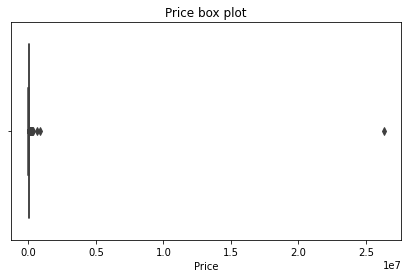

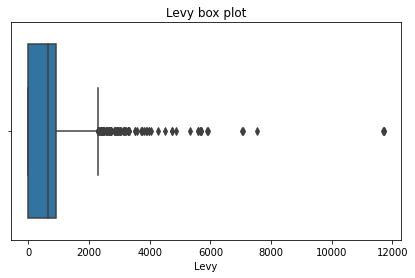

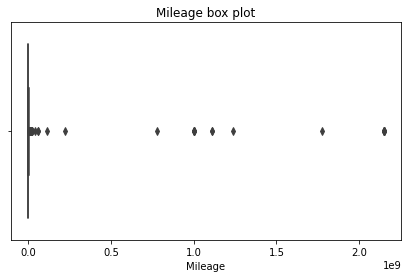

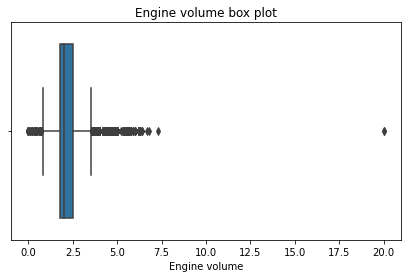

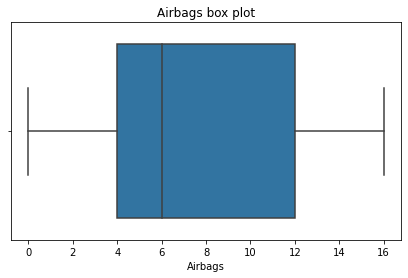

In [ ]:
# 연속형 변수 이상치 확인
import seaborn as sns
import matplotlib.pyplot as plt

for i in ['Price','Levy','Mileage','Engine volume','Airbags']:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=i,data = car)
    plt.title(f'{i} box plot')

In [ ]:
# 이상치 제거하는 함수
def outlier(data,columns):
    for i in columns:
        Q1 = data[i].quantile(0.25)
        Q3 = data[i].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        data = data[~((data[i]<lower)|(data[i]>upper))]

    return data

In [ ]:
# 이상치 제거
car = outlier(car,['Price','Levy','Mileage','Engine volume'])

In [ ]:
# 이상치 잘 제거되었는지 확인
print(car.shape)
display(car[['Price','Levy','Mileage','Engine volume']].describe().T)

(16252, 18)


,count,mean,std,min,25%,50%,75%,max
Price,16252.0,14256.056608,11299.507287,1.0,5018.0,12544.0,20385.0,47120.0
Levy,16252.0,577.966343,462.415571,0.0,0.0,640.0,878.0,2209.0
Mileage,16252.0,130822.345804,80549.813928,0.0,71000.0,125000.0,180000.0,364523.0
Engine volume,16252.0,2.148302,0.618518,0.5,1.6,2.0,2.5,3.7


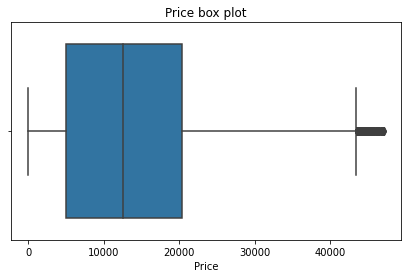

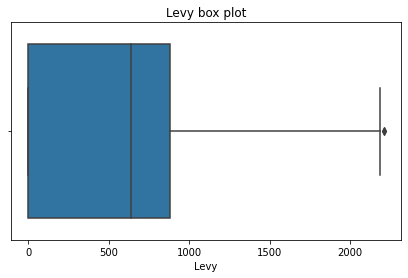

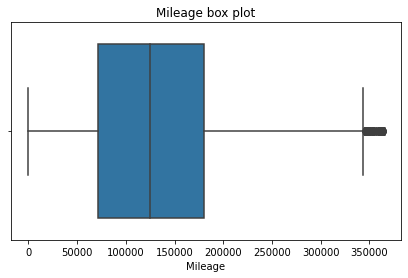

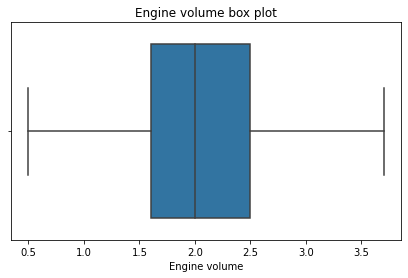

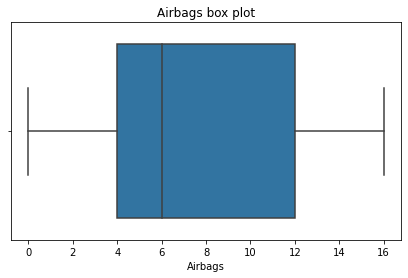

In [ ]:
for i in ['Price','Levy','Mileage','Engine volume','Airbags']:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=i,data = car)
    plt.title(f'{i} box plot')

- 이상치가 잘 제거되었음을 확인

In [ ]:
# 범주형 변수 nunique, value_counts 확인
cat_col = ['Manufacturer', 'Model', 'Category','Leather interior', 'Fuel type'
       ,'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Turbo']
for i in cat_col:
  print(f'[{i}] value counts')
  print(f'{i} nunique :',car[i].nunique(),'\n')
  print(car[i].value_counts())
  print('--------------------------------------------------')

[Manufacturer] value counts
Manufacturer nunique : 60 

TOYOTA           3232
HYUNDAI          3146
MERCEDES-BENZ    1622
CHEVROLET        1011
FORD              969
HONDA             885
BMW               805
NISSAN            607
VOLKSWAGEN        549
LEXUS             470
SSANGYONG         415
KIA               409
OPEL              374
MITSUBISHI        271
SUBARU            269
AUDI              224
MAZDA             167
JEEP              103
DAEWOO             91
FIAT               76
SUZUKI             73
DODGE              67
MINI               46
VAZ                44
RENAULT            36
CHRYSLER           23
JAGUAR             22
VOLVO              19
SKODA              18
LAND ROVER         18
INFINITI           18
PORSCHE            18
PEUGEOT            16
ACURA              15
BUICK              15
DAIHATSU           12
CADILLAC           11
GMC                10
CITROEN             9
UAZ                 9
GAZ                 9
SCION               7
LINCOLN             

In [ ]:
# 높은 카디널리티를 갖는 특성 삭제 -> Model : 1364개, Manufacturer : 60개
car = car.drop(columns=['Manufacturer','Model'])

In [ ]:
car.shape

(16252, 16)

- 전처리 후 데이터 shape이 (19237, 18)에서 (16252, 16)으로 수정되었음

## 4. EDA

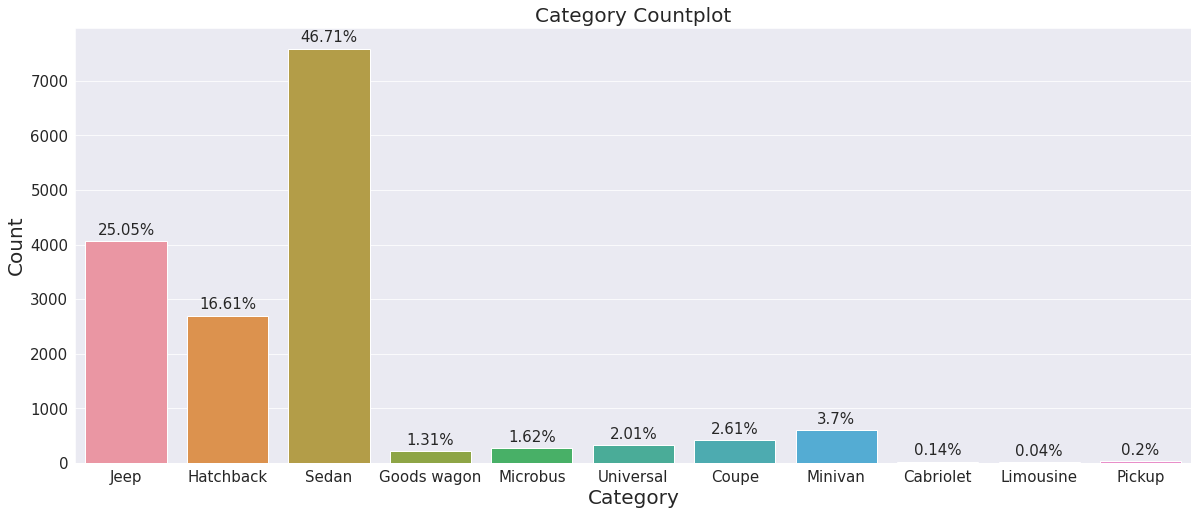

In [ ]:
# 범주형 변수 시각화 - Category
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,8))
g = sns.countplot(data=car, x='Category')
plt.title('Category Countplot',fontdict={'fontsize' : 20})
plt.xlabel('Category',fontsize=20)
plt.ylabel('Count',fontsize=20)
g.set_xticklabels(labels=car['Category'].unique(),size=15)
g.set_yticklabels(labels=[0,1000,2000,3000,4000,5000,6000,7000],size=15)
total = car.Category.value_counts().sum()
for p in ax.patches:
  ax.annotate(f'{round(p.get_height()/total*100,2)}%',(p.get_x()+p.get_width()/2.,p.get_height()+200),ha='center',va='center',fontsize=15)

- 차량 종류로는 세단>지프>해치백 순서로 데이터가 많음

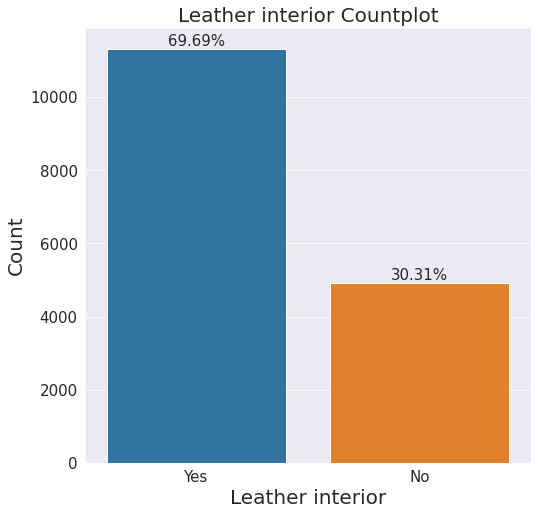

In [ ]:
# 범주형 변수 시각화 - Leather interior
fig, ax = plt.subplots(figsize=(8,8))
g = sns.countplot(data=car, x='Leather interior')
plt.title('Leather interior Countplot',fontdict={'fontsize' : 20})
plt.xlabel('Leather interior',fontsize=20)
plt.ylabel('Count',fontsize=20)
g.set_xticklabels(labels=car['Leather interior'].unique(),size=15)
g.set_yticklabels(labels=[0,2000,4000,6000,8000,10000],size=15)
total = car['Leather interior'].value_counts().sum()
for p in ax.patches:
  ax.annotate(f'{round(p.get_height()/total*100,2)}%',(p.get_x()+p.get_width()/2.,p.get_height()+200),ha='center',va='center',fontsize=15)

- 가죽 인테리어가 되어있는 차량은 69.9%, 아닌 차량은 30.31%의 비율로 데이터가 구성되어있음

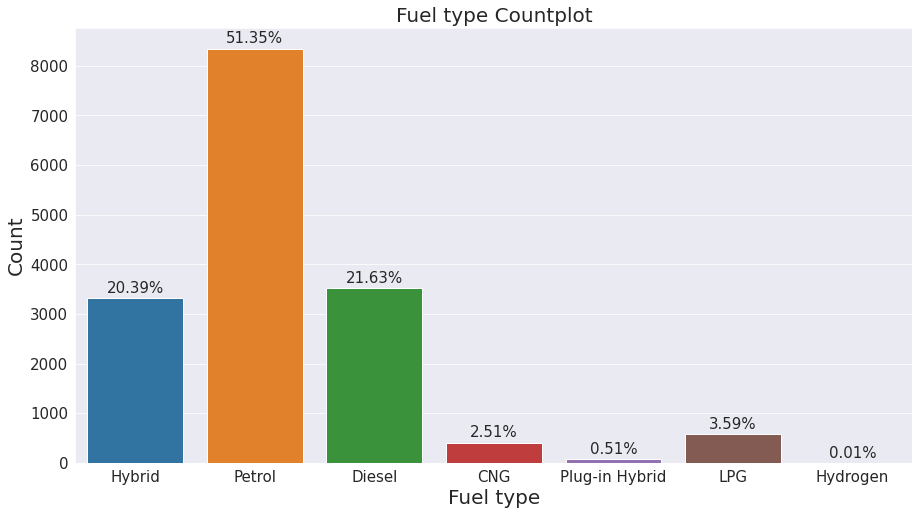

In [ ]:
# 범주형 변수 시각화 - Fuel type
fig, ax = plt.subplots(figsize=(15,8))
g = sns.countplot(data=car, x='Fuel type')
plt.title('Fuel type Countplot',fontdict={'fontsize' : 20})
plt.xlabel('Fuel type',fontsize=20)
plt.ylabel('Count',fontsize=20)
g.set_xticklabels(labels=car['Fuel type'].unique(),size=15)
g.set_yticklabels(labels=[0,1000,2000,3000,4000,5000,6000,7000,8000],size=15)
total = car['Fuel type'].value_counts().sum()
for p in ax.patches:
  ax.annotate(f'{round(p.get_height()/total*100,2)}%',(p.get_x()+p.get_width()/2.,p.get_height()+200),ha='center',va='center',fontsize=15)

- 연료 유형으로는 휘발류>디젤>하이브리드 순서로 데이터가 많음

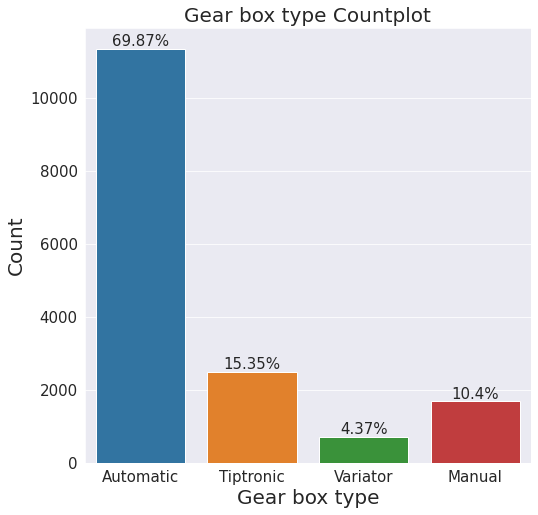

In [ ]:
# 범주형 변수 시각화 - Gear box type
fig, ax = plt.subplots(figsize=(8,8))
g = sns.countplot(data=car, x='Gear box type')
plt.title('Gear box type Countplot',fontdict={'fontsize' : 20})
plt.xlabel('Gear box type',fontsize=20)
plt.ylabel('Count',fontsize=20)
g.set_xticklabels(labels=car['Gear box type'].unique(),size=15)
g.set_yticklabels(labels=[0,2000,4000,6000,8000,10000],size=15)
total = car['Gear box type'].value_counts().sum()
for p in ax.patches:
  ax.annotate(f'{round(p.get_height()/total*100,2)}%',(p.get_x()+p.get_width()/2.,p.get_height()+200),ha='center',va='center',fontsize=15)

- 기어 유형으로는 Automatic>Tiptronic>Manual>Variator 순서로 데이터가 많음

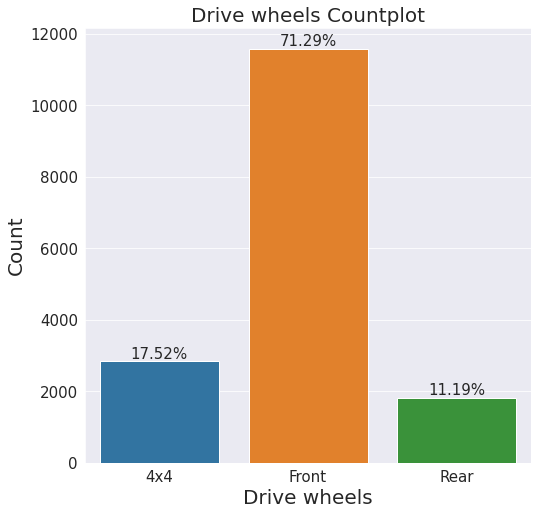

In [ ]:
# 범주형 변수 시각화 - Drive wheels
fig, ax = plt.subplots(figsize=(8,8))
g = sns.countplot(data=car, x='Drive wheels')
plt.title('Drive wheels Countplot',fontdict={'fontsize' : 20})
plt.xlabel('Drive wheels',fontsize=20)
plt.ylabel('Count',fontsize=20)
g.set_xticklabels(labels=car['Drive wheels'].unique(),size=15)
g.set_yticklabels(labels=[0,2000,4000,6000,8000,10000,12000],size=15)
total = car['Drive wheels'].value_counts().sum()
for p in ax.patches:
  ax.annotate(f'{round(p.get_height()/total*100,2)}%',(p.get_x()+p.get_width()/2.,p.get_height()+200),ha='center',va='center',fontsize=15)

- Drive wheels 변수는 Front가 71.29%, 4x4가 17.52%, Rear가 11.19%로 구성되어있음

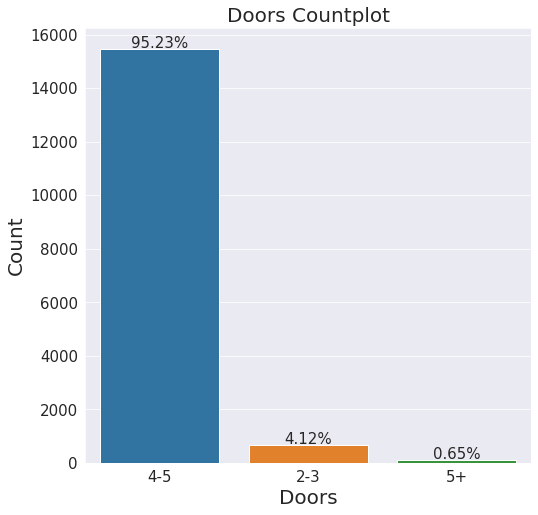

In [ ]:
# 범주형 변수 시각화 - Doors
fig, ax = plt.subplots(figsize=(8,8))
g = sns.countplot(data=car, x='Doors')
plt.title('Doors Countplot',fontdict={'fontsize' : 20})
plt.xlabel('Doors',fontsize=20)
plt.ylabel('Count',fontsize=20)
g.set_xticklabels(labels=car['Doors'].unique(),size=15)
g.set_yticklabels(labels=[0,2000,4000,6000,8000,10000,12000,14000,16000],size=15)
total = car['Doors'].value_counts().sum()
for p in ax.patches:
  ax.annotate(f'{round(p.get_height()/total*100,2)}%',(p.get_x()+p.get_width()/2.,p.get_height()+200),ha='center',va='center',fontsize=15)

- 문의 갯수는 4개에서 5개 사이의 자동차가 95.23%로 대부분 차지하고 있음

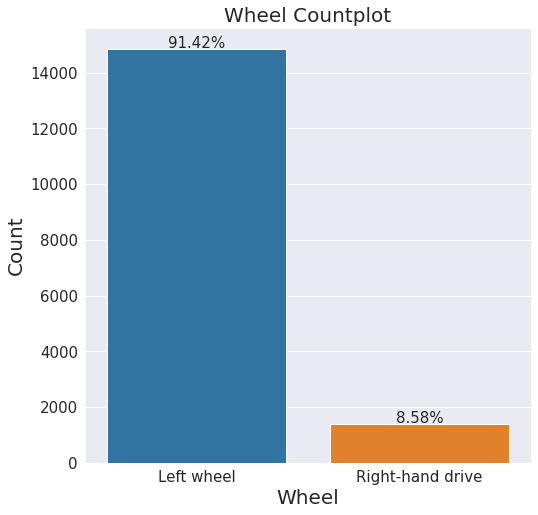

In [ ]:
# 범주형 변수 시각화 - Wheel
fig, ax = plt.subplots(figsize=(8,8))
g = sns.countplot(data=car, x='Wheel')
plt.title('Wheel Countplot',fontdict={'fontsize' : 20})
plt.xlabel('Wheel',fontsize=20)
plt.ylabel('Count',fontsize=20)
g.set_xticklabels(labels=car['Wheel'].unique(),size=15)
g.set_yticklabels(labels=[0,2000,4000,6000,8000,10000,12000,14000],size=15)
total = car['Wheel'].value_counts().sum()
for p in ax.patches:
  ax.annotate(f'{round(p.get_height()/total*100,2)}%',(p.get_x()+p.get_width()/2.,p.get_height()+200),ha='center',va='center',fontsize=15)

- Wheel 변수는 Left wheel이 91.42%로 대부분 차지하고 있음

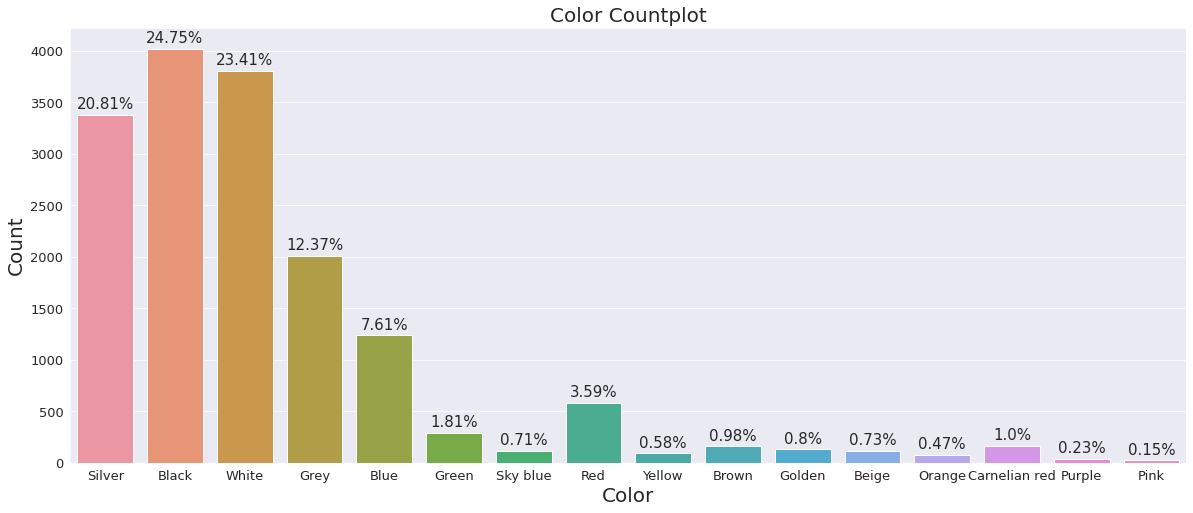

In [ ]:
# 범주형 변수 시각화 - Color
fig, ax = plt.subplots(figsize=(20,8))
g = sns.countplot(data=car, x='Color')
plt.title('Color Countplot',fontdict={'fontsize' : 20})
plt.xlabel('Color',fontsize=20)
plt.ylabel('Count',fontsize=20)
g.set_xticklabels(labels=car['Color'].unique(),size=13)
g.set_yticklabels(labels=[0,500,1000,1500,2000,2500,3000,3500,4000],size=13)
total = car['Color'].value_counts().sum()
for p in ax.patches:
  ax.annotate(f'{round(p.get_height()/total*100,2)}%',(p.get_x()+p.get_width()/2.,p.get_height()+100),ha='center',va='center',fontsize=15)

- 차량 색상은 블랙>화이트>실버 순서로 데이터가 많음

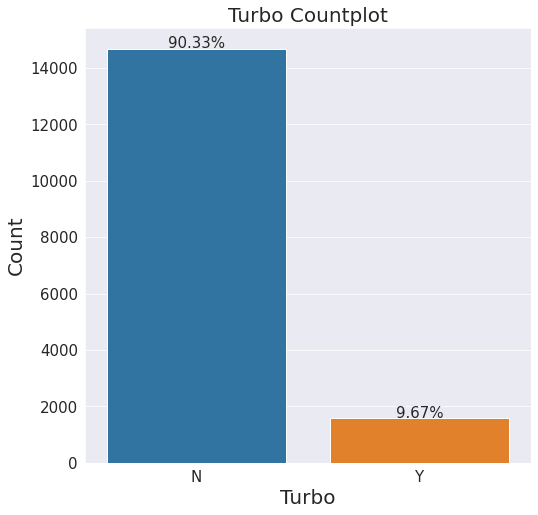

In [ ]:
# 범주형 변수 시각화 - Turbo
fig, ax = plt.subplots(figsize=(8,8))
g = sns.countplot(data=car, x='Turbo')
plt.title('Turbo Countplot',fontdict={'fontsize' : 20})
plt.xlabel('Turbo',fontsize=20)
plt.ylabel('Count',fontsize=20)
g.set_xticklabels(labels=car['Turbo'].unique(),size=15)
g.set_yticklabels(labels=[0,2000,4000,6000,8000,10000,12000,14000],size=15)
total = car['Turbo'].value_counts().sum()
for p in ax.patches:
  ax.annotate(f'{round(p.get_height()/total*100,2)}%',(p.get_x()+p.get_width()/2.,p.get_height()+200),ha='center',va='center',fontsize=15)

- 터보엔진를 갖고있는 차량이 90.33%를 차지하고 있음

In [ ]:
# 연속형 변수 describe 확인
car[['Price','Levy','Prod. year','Mileage','Engine volume','Cylinders','Airbags']].describe()

,Price,Levy,Prod. year,Mileage,Engine volume,Cylinders,Airbags
count,16252.000000,16252.000000,16252.000000,16252.000000,16252.000000,16252.000000,16252.000000
mean,14256.056608,577.966343,2010.768828,130822.345804,2.148302,4.381061,6.600480
std,11299.507287,462.415571,5.538685,80549.813928,0.618518,0.894437,4.258023
min,1.000000,0.000000,1939.000000,0.000000,0.500000,1.000000,0.000000
25%,5018.000000,0.000000,2009.000000,71000.000000,1.600000,4.000000,4.000000
50%,12544.000000,640.000000,2012.000000,125000.000000,2.000000,4.000000,6.000000
75%,20385.000000,878.000000,2014.000000,180000.000000,2.500000,4.000000,12.000000
max,47120.000000,2209.000000,2020.000000,364523.000000,3.700000,16.000000,16.000000


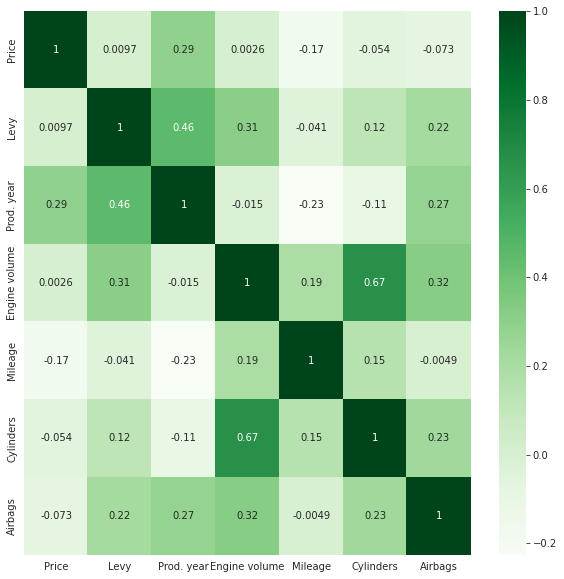

In [ ]:
# 상관계수 확인
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.heatmap(car.corr(),cmap='Greens',annot=True);

- 타겟값인 Price와 가장 상관계수가 높은 변수는 생산년도(Prod. year)이다.

##5. 모델링

In [ ]:
# 기준모델 설정 : 타겟의 평균값
baseline = car['Price'].mean()
print('Baseline Model :',round(baseline,3))

# 평가지표 설정 : R2 Score
from sklearn.metrics import r2_score

baseline_pred = pd.DataFrame([baseline] * len(car['Price']), columns = ['bs_pred'])
print('Baseline predict R2 score :',r2_score(car['Price'], baseline_pred))

Baseline Model : 14256.057
Baseline predict R2 score : 0.0


In [ ]:
# train, val, test set split -> 6:2:2 비율로 split
from sklearn.model_selection import train_test_split

target = car['Price']
features = car.drop(columns = ['Price'])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print('X_train size :', X_train.shape, '\ny_train size :', y_train.shape,
      '\n\nX_val size :', X_val.shape, '\ny_val size :', y_val.shape,
      '\n\nX_test size :', X_test.shape, '\ny_test size :', y_test.shape)

X_train size : (9750, 15) 
y_train size : (9750,) 

X_val size : (3251, 15) 
y_val size : (3251,) 

X_test size : (3251, 15) 
y_test size : (3251,)


In [ ]:
# 여러 회귀모델과 인코더 적용해보기
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

pd.options.display.float_format = '{:.5f}'.format

regression = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), RandomForestRegressor(), GradientBoostingRegressor(), XGBRegressor(objective = 'reg:squarederror')]
encoder = [OrdinalEncoder(), TargetEncoder()]

res = pd.DataFrame()
for i in encoder:
    for j in regression:
        pipe = make_pipeline(i,j)

        pipe.fit(X_train, y_train)
        y_val_predicted = pipe.predict(X_val)

        res.loc['val_r2','{}_{}'.format(str(i)[:3],str(j)[:3])] = r2_score(y_val, y_val_predicted)
        res.loc['val_mse','{}_{}'.format(str(i)[:3],str(j)[:3])] = mean_squared_error(y_val, y_val_predicted)
        res.loc['val_rmse','{}_{}'.format(str(i)[:3],str(j)[:3])] = np.sqrt(mean_squared_error(y_val, y_val_predicted))
        res.loc['val_mae','{}_{}'.format(str(i)[:3],str(j)[:3])] = mean_absolute_error(y_val, y_val_predicted)

res.T.sort_values('val_r2',ascending=False).T

,Tar_Ran,Ord_Ran,Ord_Gra,Ord_XGB,Tar_XGB,Tar_Gra,Tar_Las,Tar_Rid,Tar_Lin,Tar_Ela,Ord_Lin,Ord_Rid,Ord_Las,Ord_Ela
val_r2,0.74940,0.74758,0.61631,0.61465,0.61072,0.60710,0.33339,0.33338,0.33338,0.33276,0.24243,0.24241,0.24237,0.20540
val_mse,31187661.99545,31414152.27392,47750353.25433,47956220.46790,48446343.42893,48896082.85610,82959876.09432,82960466.08538,82960514.92874,83037319.35035,94279937.57778,94281270.92917,94286765.24841,98888118.08665
val_rmse,5584.59148,5604.83294,6910.16304,6925.04299,6960.34076,6992.57341,9108.23123,9108.26362,9108.26630,9112.48151,9709.78566,9709.85432,9710.13724,9944.25050
val_mae,3506.84063,3521.76757,5046.02057,5040.83160,5050.30328,5074.81543,7072.05411,7072.12557,7072.13350,7068.26965,7550.67369,7550.67216,7550.74479,7717.15317




* 검증 세트의 R2 Score가 가장 좋은 Target Encoder와 RandomForestRegressor 선택하여 하이퍼파라미터 설정 후 모델링



In [ ]:
# RandomizedSearchCV 이용하여 최적의 파라미터 찾기
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

pipe = make_pipeline(
    TargetEncoder(),
    RandomForestRegressor()
)
dists = {
    'targetencoder__min_samples_leaf': randint(1, 50), # 리프노드가 되기 위해 필요한 최소한의 샘플 데이터 수
    'randomforestregressor__min_samples_leaf' : randint(1,50), # 리프노드가 되기 위해 필요한 최소한의 샘플 데이터 수
    'randomforestregressor__n_estimators': randint(100, 2000), # 결정트리의 개수
    'randomforestregressor__max_depth': [None, 10, 15, 20], # 트리의 최대 깊이
    'randomforestregressor__max_features': uniform(0, 1) # 최적의 분할을 위해 고려할 최대 feature 개수
}

clf = RandomizedSearchCV(
    pipe,
    param_distributions=dists,
    n_iter=20,
    cv=3,
    scoring='r2',
    random_state = 42,
    verbose=3,
    n_jobs=-1
)

clf.fit(X_train, y_train)
print("Optimal Hyperparameter:", clf.best_params_)
print("R2 score:", clf.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimal Hyperparameter: {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.9832308858067882, 'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__n_estimators': 1608, 'targetencoder__min_samples_leaf': 7}
R2 score: 0.7164808903322265


In [ ]:
# 찾은 최적의 파라미터 적용하여 모델 검증
pipe = clf.best_estimator_

y_val_pred = pipe.predict(X_val)

print('val R^2 :',r2_score(y_val, y_val_pred))
print('val MSE :',mean_squared_error(y_val, y_val_pred))
print('val RMSE :',np.sqrt(mean_squared_error(y_val, y_val_pred)))
print('val MAE :',mean_absolute_error(y_val, y_val_pred))

val R^2 : 0.7390076813742155
val MSE : 32480410.874366578
val RMSE : 5699.158786554957
val MAE : 3751.9580044563777


In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,8,10,13,0,11,1,9,16,17,2,3,6,5,15,18,7,4,12,14,19
mean_fit_time,41.36682,19.50340,6.04871,22.75556,11.23679,17.10027,4.87364,14.03580,8.27570,14.45215,2.50174,17.76291,8.59474,2.89459,17.00484,9.18739,7.42724,9.66350,4.26212,9.15228
std_fit_time,1.87003,0.13342,0.03561,1.63677,0.01275,0.41661,0.02224,0.06112,0.01092,0.70172,0.02794,0.74575,0.02242,0.02752,0.10108,0.83435,0.05028,0.82307,0.06408,0.30180
mean_score_time,1.29058,1.02738,0.48651,0.93687,1.06566,0.78237,0.30733,1.11069,0.57850,0.50645,0.33487,0.82135,0.48011,0.21391,0.57618,0.56604,0.66718,0.89059,0.47706,1.08127
std_score_time,0.01052,0.02086,0.00742,0.21540,0.01901,0.00876,0.00299,0.02287,0.00668,0.00271,0.00376,0.05393,0.00410,0.00211,0.01359,0.04054,0.01150,0.00380,0.03004,0.23312
param_randomforestregressor__max_depth,15,20,20,15,20,None,None,20,None,15,15,15,10,10,10,15,10,15,20,15
param_randomforestregressor__max_features,0.98323,0.56329,0.31171,0.79654,0.24103,0.59685,0.45050,0.32654,0.38868,0.86618,0.02058,0.61185,0.52476,0.39515,0.96526,0.45607,0.21234,0.17336,0.18485,0.16527
param_randomforestregressor__min_samples_leaf,3,9,6,15,7,19,18,14,18,36,2,42,44,36,45,47,21,17,18,25
param_randomforestregressor__n_estimators,1608,1469,665,1230,1551,1338,487,1850,978,971,443,1599,956,369,1164,1057,1284,1685,829,1962
param_targetencoder__min_samples_leaf,7,2,42,8,8,11,25,40,24,24,44,16,49,31,29,44,12,40,44,9
params,"{'randomforestregressor__max_depth': 15, 'rand...","{'randomforestregressor__max_depth': 20, 'rand...","{'randomforestregressor__max_depth': 20, 'rand...","{'randomforestregressor__max_depth': 15, 'rand...","{'randomforestregressor__max_depth': 20, 'rand...","{'randomforestregressor__max_depth': None, 'ra...","{'randomforestregressor__max_depth': None, 'ra...","{'randomforestregressor__max_depth': 20, 'rand...","{'randomforestregressor__max_depth': None, 'ra...","{'randomforestregressor__max_depth': 15, 'rand...","{'randomforestregressor__max_depth': 15, 'rand...","{'randomforestregressor__max_depth': 15, 'rand...","{'randomforestregressor__max_depth': 10, 'rand...","{'randomforestregressor__max_depth': 10, 'rand...","{'randomforestregressor__max_depth': 10, 'rand...","{'randomforestregressor__max_depth': 15, 'rand...","{'randomforestregressor__max_depth': 10, 'rand...","{'randomforestregressor__max_depth': 15, 'rand...","{'randomforestregressor__max_depth': 20, 'rand...","{'randomforestregressor__max_depth': 15, 'rand..."


In [ ]:
# 찾은 최적의 파라미터 적용하여 테스트 셋으로 최종 모델 평가
pipe = clf.best_estimator_

y_pred = pipe.predict(X_test)

print('test R^2 :',r2_score(y_test, y_pred))
print('test MSE :',mean_squared_error(y_test, y_pred))
print('test RMSE :',np.sqrt(mean_squared_error(y_test, y_pred)))
print('test MAE :',mean_absolute_error(y_test, y_pred))

test R^2 : 0.7576478338844466
test MSE : 32527448.371339906
test RMSE : 5703.283998832594
test MAE : 3713.982298995936


## 6. 모델 해석 및 시각화

In [ ]:
# Permutation Importance 계산
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('preprocessing', TargetEncoder(min_samples_leaf=7)),
    ('rf', RandomForestRegressor(max_depth=15, max_features=0.9832308858067882, min_samples_leaf=3, n_estimators=1608, random_state=42))
])

permuter = PermutationImportance(
    pipe.named_steps['rf'],
    scoring='r2',
    n_iter=5,
    random_state=42
)

pipe.fit(X_train, y_train);
y_pred = pipe.predict(X_test)
print('r2 score :', r2_score(y_test, y_pred))

X_test_transformed = pipe.named_steps['preprocessing'].transform(X_test)

permuter.fit(X_test_transformed, y_test);

permutation_importance = pd.DataFrame({'feature' : X_test.columns, 'weight' : permuter.feature_importances_}).sort_values('weight', ascending = False)
permutation_importance

r2 score : 0.7576250950297


,feature,weight
1,Prod. year,0.52337
13,Airbags,0.48374
0,Levy,0.31783
4,Fuel type,0.20441
8,Gear box type,0.17927
5,Engine volume,0.13732
3,Leather interior,0.12789
6,Mileage,0.10195
2,Category,0.08316
14,Turbo,0.05832


In [ ]:
list(permutation_importance['feature'])

['Prod. year',
 'Airbags',
 'Levy',
 'Fuel type',
 'Gear box type',
 'Engine volume',
 'Leather interior',
 'Mileage',
 'Category',
 'Turbo',
 'Drive wheels',
 'Cylinders',
 'Color',
 'Wheel',
 'Doors']

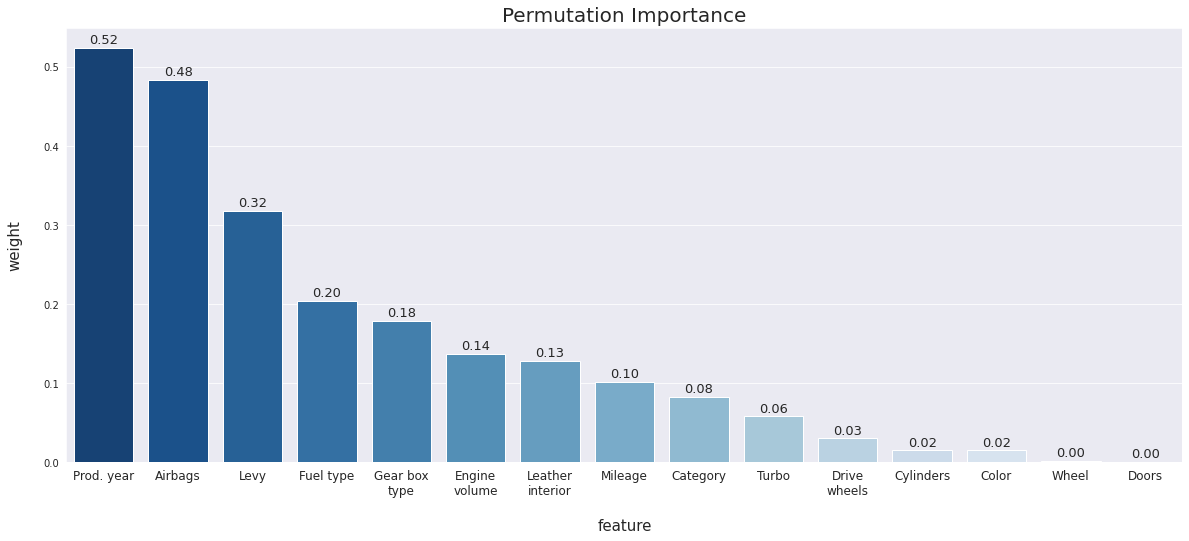

In [ ]:
# Permutation Importance 시각화
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,8))
g = sns.barplot(data=permutation_importance, x='feature',y='weight',ci=None, palette='Blues_r')
plt.title('Permutation Importance',fontdict={'fontsize' : 20})
plt.xlabel('\nfeature',fontsize=15)
plt.ylabel('weight\n',fontsize=15)
label = ['Prod. year',
 'Airbags',
 'Levy',
 'Fuel type',
 'Gear box\ntype',
 'Engine\nvolume',
 'Leather\ninterior',
 'Mileage',
 'Category',
 'Turbo',
 'Drive\nwheels',
 'Cylinders',
 'Color',
 'Wheel',
 'Doors']
g.set_xticklabels(label, size=12)

for p in ax.patches:
  ax.annotate('%.2f'% p.get_height(),(p.get_x()+p.get_width()/2.,p.get_height()+0.01),ha='center',va='center',fontsize=13)

- 생산년도가 Permutation Importance가 가장 높음

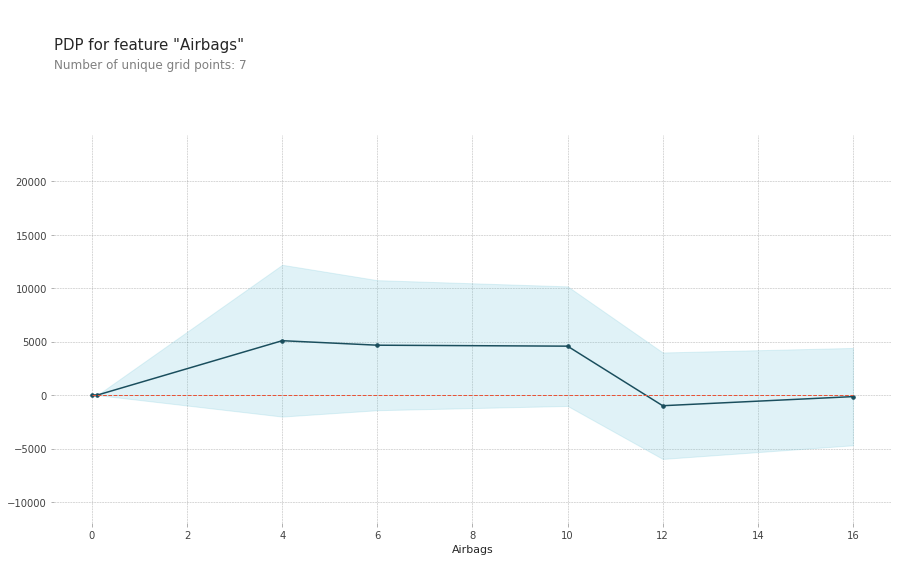

In [ ]:
# PDP Plot
from pdpbox.pdp import pdp_isolate, pdp_plot

## Airbags
isolated_airbags = pdp_isolate(
    model=pipe,
    dataset=X_test,
    model_features=X_test.columns,
    feature='Airbags',
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated_airbags, feature_name='Airbags');

- 에어백 수가 4개일 때 가격이 가장 높다. 에어백 수가 많다고 가격이 높은건 아니다.

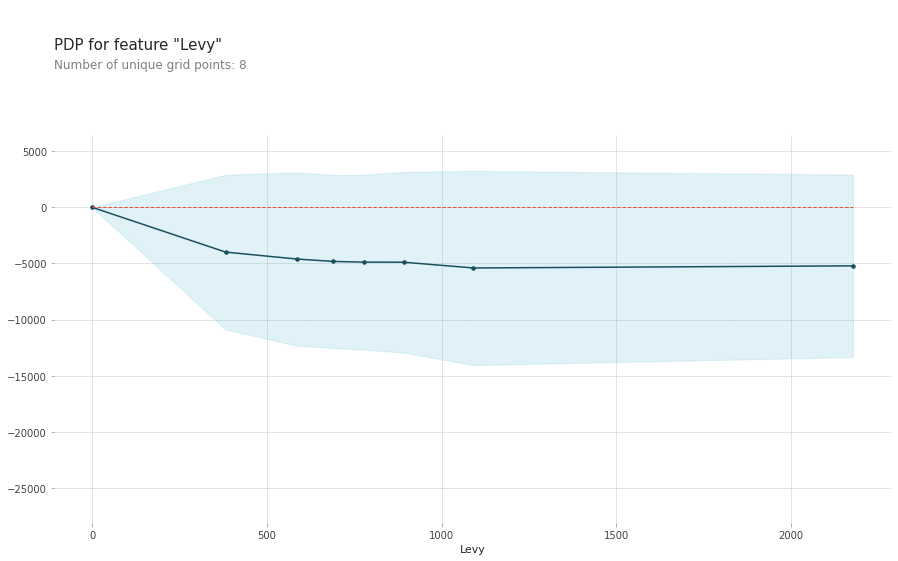

In [ ]:
## Levy
isolated_levy = pdp_isolate(
    model=pipe,
    dataset=X_test,
    model_features=X_test.columns,
    feature='Levy',
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated_levy, feature_name='Levy');

- 세금이 높을수록 가격이 낮아진다.

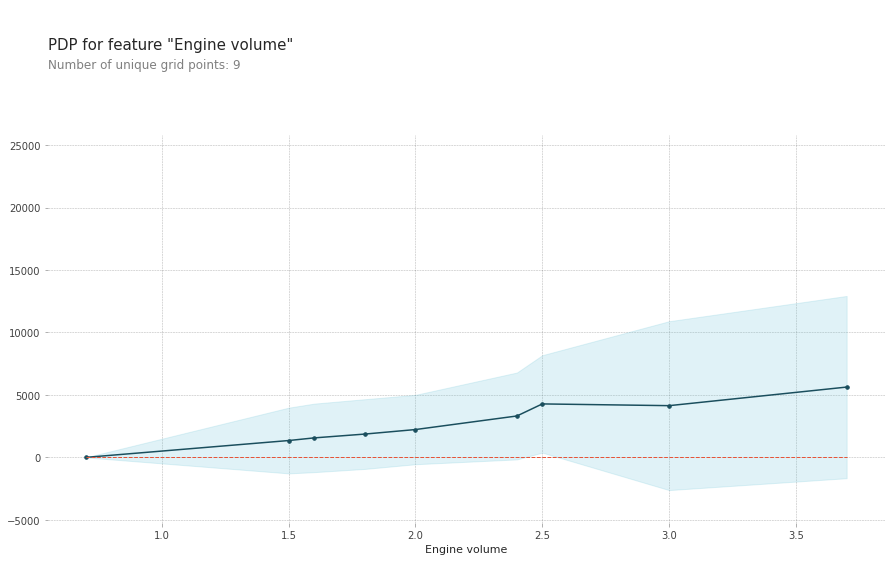

In [ ]:
## Engine volume
isolated_engine = pdp_isolate(
    model=pipe,
    dataset=X_test,
    model_features=X_test.columns,
    feature='Engine volume',
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated_engine, feature_name='Engine volume');

- 엔진 크기가 클수록 가격이 높아진다.

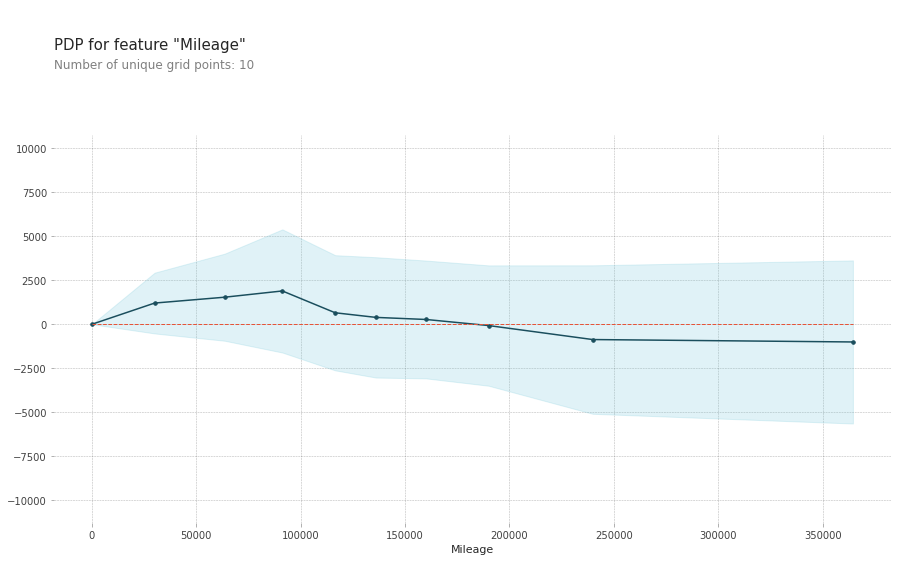

In [ ]:
## Mileage
isolated_mileage = pdp_isolate(
    model=pipe,
    dataset=X_test,
    model_features=X_test.columns,
    feature='Mileage',
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated_mileage, feature_name='Mileage');

- 주행거리가 많을수록 가격이 낮아진다.

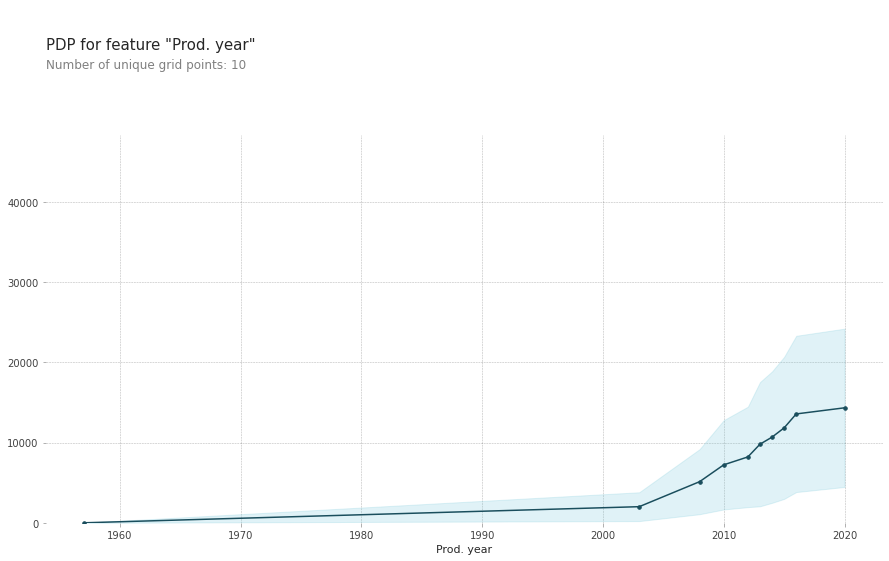

In [ ]:
## Prod. year
isolated_year = pdp_isolate(
    model=pipe,
    dataset=X_test,
    model_features=X_test.columns,
    feature='Prod. year',
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated_year, feature_name='Prod. year');

- 생산년도가 최근일수록 가격이 높아진다.

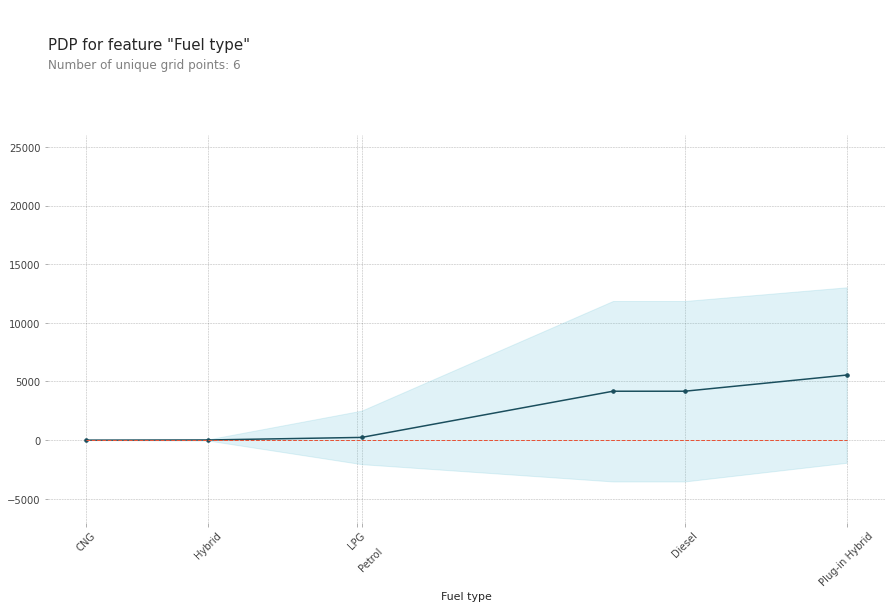

In [ ]:
## Fuel type
isolated_fuel = pdp_isolate(
    model=pipe.named_steps['rf'],
    dataset=X_test_transformed,
    model_features=X_test.columns,
    feature='Fuel type',
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated_fuel, feature_name='Fuel type');
plt.xticks([7732.10800,10285.63292,13376.18129,	13480.94599,20212.69335,23587.00000], ['CNG','Hybrid','LPG','\n\n Petrol','Diesel','Plug-in Hybrid'],rotation=45);

- Plug-in Hybrid 연료일 때 가격이 가장 높다.

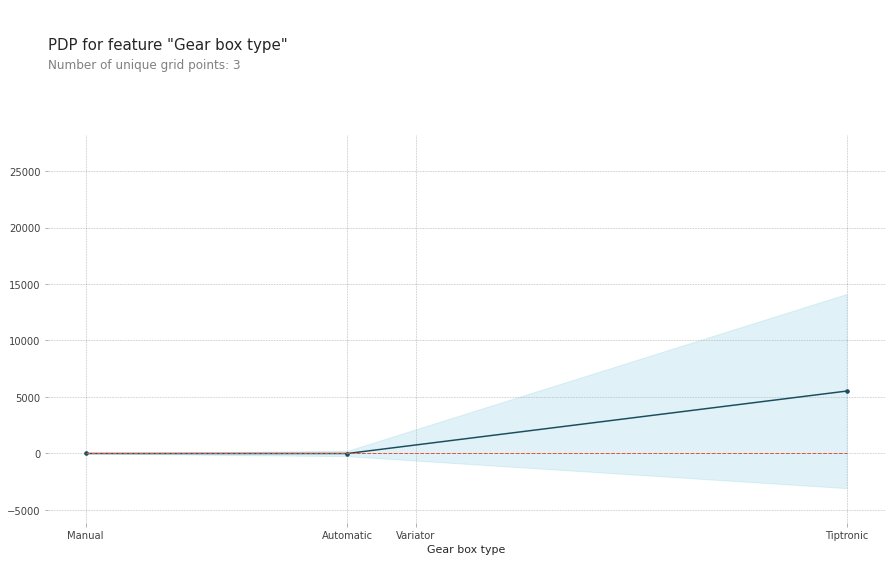

In [ ]:
## Gear box type
isolated_gear = pdp_isolate(
    model=pipe.named_steps['rf'],
    dataset=X_test_transformed,
    model_features=X_test_transformed.columns,
    feature='Gear box type',
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated_gear, feature_name='Gear box type');
plt.xticks([10774.81178,13654.54859, 14403.86620, 19148.72358], ['Manual','Automatic','Variator','Tiptronic']);

- Tiptronic 기어일 때 가격이 가장 높다.

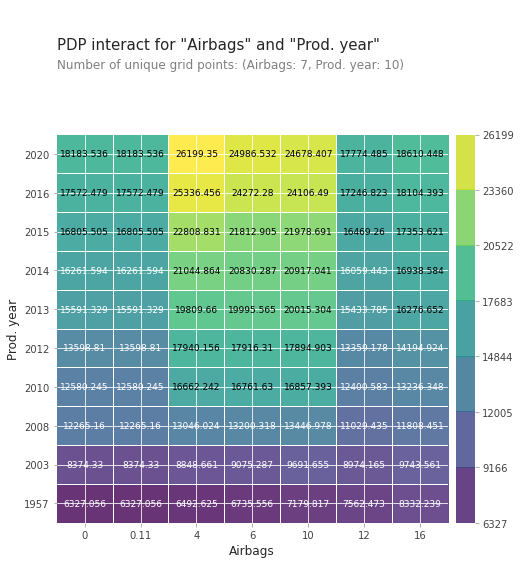

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Airbags', 'Prod. year']

interaction = pdp_interact(
    model = pipe,
    dataset = X_test,
    model_features = X_test.columns,
    features = features
)

pdp_interact_plot(
    interaction,
    plot_type = 'grid',
    feature_names = features,
);

- 특성중요도가 가장 높았던 생산년도와 에어백 수와의 특성을 함께 확인해보면, 에어백의 개수가 4개이고, 생산년도가 2020년 이상일 때 가격이 가장 높다.

In [ ]:
import shap
explainer = shap.TreeExplainer(pipe['rf'])
shap_values = explainer.shap_values(X_test_transformed.iloc[:100])

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=X_test_transformed[:100]
)

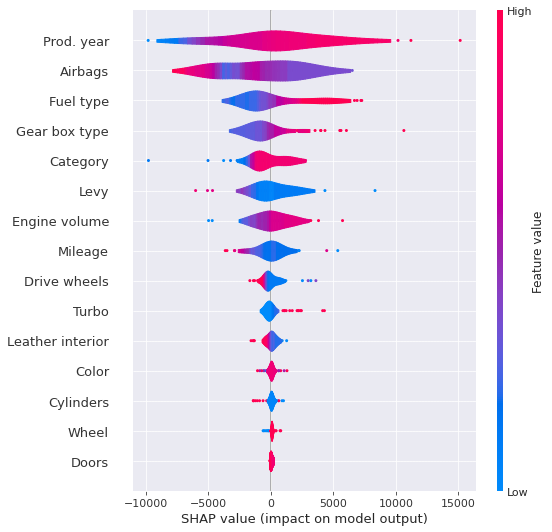

In [ ]:
import shap
explainer = shap.TreeExplainer(pipe['rf'])
shap_values = explainer.shap_values(X_test_transformed.iloc[:100])
shap.summary_plot(shap_values, X_test_transformed.iloc[:100], plot_type="violin")

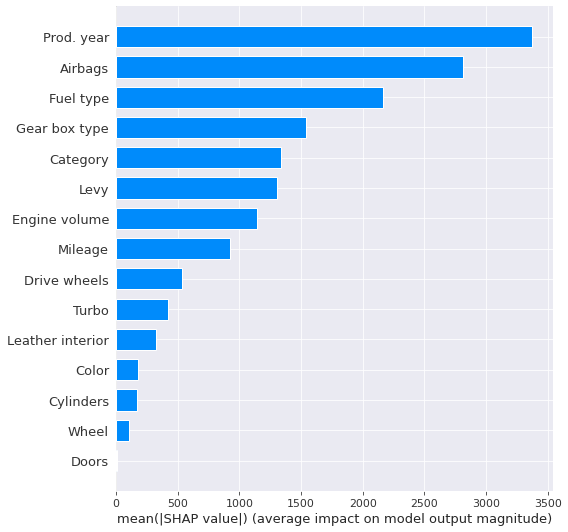

In [ ]:
shap.summary_plot(shap_values, X_test_transformed.iloc[:100], plot_type="bar") #특성들의 영향력,

- 생산년도가 가격에 가장 큰 영향을 미치며, 다음으로는 에어백 개수>연료 유형>기어 유형 순으로 영향도가 높다.

## 6. 결론

- 분석 결과
  - 생산년도가 최근일수록, 엔진볼륨은 클수록 중고차 예측 가격이 높다.
  - 주행거리가 많을수록 중고차 예측 가격이 낮다.
  중고차 가격 예측에 가장 큰 영향을 미치는 요소는 생산년도이다.

- 마무리
  - 중고차 가격 예측 모델을 통해 추후 고객들에게 신뢰도 있는 중고차 가격 비교가 가능할 것으로 보인다.
  - 최근 시세 혼란기를 겪고있는 중고차 시장에서 신뢰도 있는 가격비교는 중고차 사기를 피할 수 있는 좋은 수단이 될 수 있다고 생각한다.
  - 추가적으로 최종 테스트 세트의 R2 Score가 0.76이라는 점이 아쉬워 추후 더 세밀한 데이터 전처리와 모델 성능 개선에 도전해보고 싶다.